In [69]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report
import gc


In [70]:
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [71]:
SEED = 42

torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [72]:
# from google.colab import drive
# drive.mount('/content/drive')

In [73]:
cuda=torch.device('cuda')
device = cuda if torch.cuda.is_available() else "cpu"

In [74]:
print(device)

cuda


In [75]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

fatal: destination path 'TextGraphs17-shared-task' already exists and is not an empty directory.


In [76]:
!ls TextGraphs17-shared-task

baselines  evaluation		    README.md	   submission_example
data	   question_graph_examples  reformat_data  visualization


In [77]:
train_dev_path = "TextGraphs17-shared-task/data/tsv/train.tsv"
test_path = "TextGraphs17-shared-task/data/tsv/test.tsv"

train_dev_df = pd.read_csv(train_dev_path, sep='\t')
test_df = pd.read_csv(test_path, sep='\t')

In [78]:
train_dev_questions = list(train_dev_df["question"].unique())
test_questions = list(test_df["question"].unique())
num_train_dev_questions = len(train_dev_questions)
random.shuffle(train_dev_questions)

### Splitting train into train/dev

In [79]:
train_ratio = 0.95

num_train_questions = int(num_train_dev_questions * train_ratio)
train_questions = set(train_dev_questions[:num_train_questions])
dev_questions = set(train_dev_questions[num_train_questions:])

print(f"Questions: train - {len(train_questions)}, dev - {len(dev_questions)}, test - {len(test_questions)}")

Questions: train - 3358, dev - 177, test - 1000


In [80]:
train_df = train_dev_df[train_dev_df["question"].isin(train_questions)]
dev_df = train_dev_df[train_dev_df["question"].isin(dev_questions)]


print(f"Train: {train_df.shape}")
print(f"Dev: {dev_df.shape}")
print(f"Test: {test_df.shape}")

Train: (35796, 10)
Dev: (1876, 10)
Test: (10961, 7)


In [81]:
train_df.loc[0, "graph"]

'{\'nodes\': [{\'type\': \'QUESTIONS_ENTITY\', \'name_\': \'Q794\', \'id\': 0, \'label\': \'Iran\'}, {\'type\': \'INTERNAL\', \'name_\': \'Q207991\', \'id\': 1, \'label\': \'Pahlavi dynasty\'}, {\'type\': \'ANSWER_CANDIDATE_ENTITY\', \'name_\': \'Q7293530\', \'id\': 2, \'label\': "Ruhollah Khomeini\'s return to Iran"}], \'links\': [{\'name_\': \'P17\', \'source\': 0, \'target\': 0, \'label\': \'country\'}, {\'name_\': \'P1365\', \'source\': 0, \'target\': 1, \'label\': \'replaces\'}, {\'name_\': \'P1366\', \'source\': 1, \'target\': 0, \'label\': \'replaced by\'}, {\'name_\': \'P17\', \'source\': 2, \'target\': 1, \'label\': \'country\'}]}'

In [82]:
train_df.head()

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
1,1,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q417..."
2,2,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini,Office of the Supreme Leader of Iran,Q38823,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
3,3,Whst is the name of the head of state and high...,Iran,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,Q16045000,Q794,Q16045000,True,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
4,4,Whst is the name of the head of state and high...,Iran,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,Q63195813,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."


In [83]:
print(train_df.isnull().sum())


sample_id                    0
question                     0
questionEntity               0
answerEntity                 0
groundTruthAnswerEntity      0
answerEntityId               0
questionEntityId             0
groundTruthAnswerEntityId    0
correct                      0
graph                        0
dtype: int64


In [84]:
train_df["label"] = train_df["correct"].astype(np.float32)
dev_df["label"] = dev_df["correct"].astype(np.float32)
test_df["label"] = np.zeros(shape=test_df.shape[0], dtype=np.float32)
train_df["label"].head(5)

/tmp/ipykernel_8380/3709585686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["correct"].astype(np.float32)
/tmp/ipykernel_8380/3709585686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["label"] = dev_df["correct"].astype(np.float32)


0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: label, dtype: float32

In [85]:
train_df["graph"] = train_df["graph"].apply(eval)
dev_df["graph"] = dev_df["graph"].apply(eval)
test_df["graph"] = test_df["graph"].apply(eval)

/tmp/ipykernel_8380/1764180835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["graph"] = train_df["graph"].apply(eval)
/tmp/ipykernel_8380/1764180835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["graph"] = dev_df["graph"].apply(eval)


In [86]:
train_df.loc[0, "graph"]

{'nodes': [{'type': 'QUESTIONS_ENTITY',
   'name_': 'Q794',
   'id': 0,
   'label': 'Iran'},
  {'type': 'INTERNAL',
   'name_': 'Q207991',
   'id': 1,
   'label': 'Pahlavi dynasty'},
  {'type': 'ANSWER_CANDIDATE_ENTITY',
   'name_': 'Q7293530',
   'id': 2,
   'label': "Ruhollah Khomeini's return to Iran"}],
 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'},
  {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'},
  {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'},
  {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}

In [87]:
train_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
0,Whst is the name of the head of state and high...,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,0.0
1,Whst is the name of the head of state and high...,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,0.0
2,Whst is the name of the head of state and high...,Ruhollah Khomeini,Office of the Supreme Leader of Iran,0.0
3,Whst is the name of the head of state and high...,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,1.0
4,Whst is the name of the head of state and high...,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,0.0
5,Whst is the name of the head of state and high...,Mahmoud Ahmadinejad,Office of the Supreme Leader of Iran,0.0
6,Whst is the name of the head of state and high...,Hassan Rouhani,Office of the Supreme Leader of Iran,0.0
7,Whst is the name of the head of state and high...,Ayatollah Khamenei's Foreign Policy Orientation,Office of the Supreme Leader of Iran,0.0
8,Whst is the name of the head of state and high...,Ayatollah Ali Khamenei speaks about Iranian pr...,Office of the Supreme Leader of Iran,0.0
9,Whst is the name of the head of state and high...,Ali Khamenei bibliography,Office of the Supreme Leader of Iran,0.0


In [88]:
test_df[["question", "answerEntity"]].head(10)

,question,answerEntity
0,"After publishing A Time to Kill, which book di...",A Clash of Kings
1,"After publishing A Time to Kill, which book di...",A Feast for Crows
2,"After publishing A Time to Kill, which book di...",Fear and Loathing in Las Vegas
3,"After publishing A Time to Kill, which book di...",In Cold Blood
4,"After publishing A Time to Kill, which book di...",Into the Woods
5,"After publishing A Time to Kill, which book di...",Kongenes kamp
6,"After publishing A Time to Kill, which book di...",No Country for Old Men
7,"After publishing A Time to Kill, which book di...",No Country for Old Men
8,"After publishing A Time to Kill, which book di...",Slaughterhouse-Five
9,"After publishing A Time to Kill, which book di...",The Firm


In [89]:
# class QuestionAnswerDataset(Dataset):
#     # def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
#     #              tokenizer_truncation="only_first"):
#     #     super(QuestionAnswerDataset).__init__()

#     #     self.questions = df.question.values
#     #     self.contexts = df[context_key].values
#     #     self.labels = torch.tensor(df.label.values, dtype=torch.float32)
#     #     self.tokenizer = tokenizer
#     #     self.max_length = max_length
#     #     self.tokenized_input = [tokenizer.encode_plus(x, y,
#     #                           max_length=self.max_length,
#     #                           padding="max_length",
#     #                           truncation=tokenizer_truncation,
#     #                           return_tensors="pt", ) \
#     #                       for x, y in zip(self.questions,
#     #                                       self.contexts)]
#     #     assert len(self.questions) == len(self.contexts) == len(self.labels)
#     def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
#                  tokenizer_truncation="only_first"):
#         super(QuestionAnswerDataset, self).__init__()

#         # Filter out samples with null labels
#         self.questions = df[~df.label.isna()].question.values
#         self.contexts = df[~df.label.isna()][context_key].values
#         self.labels = torch.tensor(df[~df.label.isna()].label.values, dtype=torch.float32)
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#         self.tokenized_input = [tokenizer.encode_plus(x, y,
#                                                      max_length=self.max_length,
#                                                      padding="max_length",
#                                                      truncation=tokenizer_truncation,
#                                                      return_tensors="pt", )
#                                for x, y in zip(self.questions, self.contexts)]
#         assert len(self.questions) == len(self.contexts) == len(self.labels)


#     def __len__(self):
#         return len(self.questions)

#     def __getitem__(self, idx):
#         labels = self.labels[idx]
#         if labels.ndim == 0:
#             print(labels)
#             # If the label is a scalar, convert it to a 1-dimensional tensor
#             labels = torch.tensor(labels)
#             labels = labels.unsqueeze(0)


#         return {
#                 "input_ids": self.tokenized_input[idx]["input_ids"][0],
#                 "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
#                 "labels": self.labels[idx]}
    

In [90]:
class QuestionAnswerDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first"):
        super(QuestionAnswerDataset, self).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        assert len(self.questions) == len(self.contexts) == len(self.labels)

    def __len__(self):
        return len(self.questions)

    # def __getitem__(self, idx):
    #     source_ids = self.tokenized_input[idx]["input_ids"].squeeze()
    #     source_mask = self.tokenized_input[idx]["attention_mask"].squeeze()
    #     labels = self.labels[idx].unsqueeze(0)
    #     if torch.isnan(labels).any():
    #         labels[torch.isnan(labels)] = 0
    #     target_mask = torch.ones_like(labels)

    #     # Shift the target_ids one position to the right to create the decoder_input_ids
    #     decoder_input_ids = torch.cat([torch.tensor([self.tokenizer.bos_token_id]), labels[:-1]], dim=-1)
    #     decoder_attention_mask = torch.ones_like(decoder_input_ids)

    #     return {
    #         "input_ids": source_ids,
    #         "attention_mask": source_mask,
    #         "decoder_input_ids": decoder_input_ids,
    #         "decoder_attention_mask": decoder_attention_mask,
    #         "labels": labels
    #     }

    def __getitem__(self, idx):
        labels = self.labels[idx] #target_ids
        if labels.ndim == 0:
            #print(labels)
            # If the label is a scalar, convert it to a 1-dimensional tensor
            labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)
            labels = labels.unsqueeze(0)
        # need target_mask
        target_mask = torch.zeros_like(labels)


        return {
                "input_ids": self.tokenized_input[idx]["input_ids"].squeeze(),
                "attention_mask" : self.tokenized_input[idx]["attention_mask"].squeeze(),
                "labels": labels,
                "target_mask": target_mask}


In [91]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

# # model_name="roberta-base"
# model_name="sentence-transformers/all-mpnet-base-v2"

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# bert_model = AutoModel.from_pretrained(model_name)

# freeze_embeddings = True
# if freeze_embeddings:
#     for param in bert_model.embeddings.parameters():
#         param.requires_grad = False

# freeze_layer_count = 5
# if freeze_layer_count > 0:
#     for layer in bert_model.encoder.layer[:freeze_layer_count]:
#         for param in layer.parameters():
#             param.requires_grad = False

# Load the T5 model and tokenizer
bert_model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Trainable params:  222903552


In [92]:
train_df_filtered = train_df.copy()
train_df_filtered.sort_values(by=["label", ], ascending=False, inplace=True)
train_df_filtered["label"].head()

10966    1.0
3784     1.0
16770    1.0
8431     1.0
30075    1.0
Name: label, dtype: float32

In [93]:
print(train_df_filtered.shape)
train_df_filtered.drop_duplicates(subset=["question", "answerEntity"], keep="first", inplace=True)
print(train_df_filtered.shape)

(35796, 11)
(33542, 11)


In [94]:
print(train_df_filtered.isnull().sum())


sample_id                    0
question                     0
questionEntity               0
answerEntity                 0
groundTruthAnswerEntity      0
answerEntityId               0
questionEntityId             0
groundTruthAnswerEntityId    0
correct                      0
graph                        0
label                        0
dtype: int64


In [95]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df_filtered, tokenizer=tokenizer, max_length=max_length)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length)

In [96]:
idx_bound = 2
for i in range(idx_bound):
    d = train_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    d = dev_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    d = test_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    print('---')

 ▁Which ▁was ▁the ▁first ▁Pi x ar ▁movie ▁to ▁not ▁be ▁released ▁in ▁the ▁1990 ' s ? </s> ▁Monster s , ▁Inc . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 ▁Who ▁wrote ▁Looking ▁for ▁Alaska ? </s> ▁Tom ▁Rob bin s </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

/tmp/ipykernel_8380/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)


In [97]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

## Use T5 model

In [30]:

# Set up the Seq2SeqTrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,  # Use mixed precision training
)

# Create the data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="max_length",
    max_length=256,
    label_pad_token_id=tokenizer.pad_token_id,
    return_tensors="pt"
)

# Create the Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the model
train_results = trainer.train()
trainer.save_model()  # Saves the tokenizer too for easy upload

metrics = train_results.metrics
metrics["train_samples"] = len(train_dataset)

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zhaowei-wang. Use `wandb login --relogin` to force relogin


/tmp/ipykernel_4070/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)


Epoch,Training Loss,Validation Loss
1,0.389900,0.311334
2,0.333500,0.306096
3,0.313900,0.323491
4,0.287300,0.333848
5,0.244400,0.366504


/tmp/ipykernel_4070/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)
/tmp/ipykernel_4070/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)
/tmp/ipykernel_4070/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)
/tmp/ipykernel_4070/65407

***** train metrics *****
  epoch                    =        5.0
  total_flos               = 47557208GF
  train_loss               =     0.3566
  train_runtime            = 0:55:31.55
  train_samples            =      33542
  train_samples_per_second =      50.34
  train_steps_per_second   =      3.147
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9494448040>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f94f867dd60, execution_count=30 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f94f867d1c0, raw_cell="
# Set up the Seq2SeqTrainingArguments
training_ar.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bsongcpu2.cse.ust.hk/home/zwanggy/TextGraphs17/baselines/t5.ipynb#X46sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _pause_backend() takes 1 positional argument but 2 were given

In [31]:
# Evaluate the model
metrics = trainer.evaluate(dev_dataset)
print(metrics)


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9494448040>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f94344ad5e0, raw_cell="# Evaluate the model
metrics = trainer.evaluate(de.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bsongcpu2.cse.ust.hk/home/zwanggy/TextGraphs17/baselines/t5.ipynb#X50sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _resume_backend() takes 1 positional argument but 2 were given

/tmp/ipykernel_4070/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)


{'eval_loss': 0.36650389432907104, 'eval_runtime': 7.875, 'eval_samples_per_second': 238.223, 'eval_steps_per_second': 14.984, 'epoch': 5.0}
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9494448040>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f94344ada30, execution_count=31 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f94344ad5e0, raw_cell="# Evaluate the model
metrics = trainer.evaluate(de.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bsongcpu2.cse.ust.hk/home/zwanggy/TextGraphs17/baselines/t5.ipynb#X50sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _pause_backend() takes 1 positional argument but 2 were given

In [32]:

# Generate predictions
predictions = trainer.predict(test_dataset)

# Extract the predicted labels
true_labels = predictions.label_ids
pred_labels = predictions.predictions.argmax(-1)

# Create a dataframe with the predictions
#test_df[""] = true_labels
test_df["prediction"] = pred_labels

# Save the predictions to a TSV file
test_pred_path = "test_pred_t5_model.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9494448040>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f94344ad2e0, raw_cell="
# Generate predictions
predictions = trainer.pred.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bsongcpu2.cse.ust.hk/home/zwanggy/TextGraphs17/baselines/t5.ipynb#X51sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


TypeError: _resume_backend() takes 1 positional argument but 2 were given

/tmp/ipykernel_4070/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)
/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9494448040>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f94344ad1f0, execution_count=32 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f94344ad2e0, raw_cell="
# Generate predictions
predictions = trainer.pred.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bsongcpu2.cse.ust.hk/home/zwanggy/TextGraphs17/baselines/t5.ipynb#X51sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _pause_backend() takes 1 positional argument but 2 were given

In [98]:
def train(model, iterator, optimizer, criterion, device,
          train_history=None, valid_history=None, decoder_input_ids=None, decoder_attention_mask=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        #output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask
        )
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            true_labels.extend(labels.cpu().numpy())
            labels = labels.to(device)


            output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = output.cpu().numpy()
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(output, labels)

            pred_labels.extend(batch_pred_labels)
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [99]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [100]:
def train_evaluate(bert_classifier, train_loader, dev_loader, optimizer, criterion, n_epochs,  checkpoint_fname, device):
    train_history = []
    valid_history = []
    valid_history_f1 = []

    best_valid_loss = float('inf')
    best_f1_score = 0.0

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(bert_classifier, train_loader, optimizer, criterion, device, train_history, valid_history, )
        valid_loss, valid_f1_score = evaluate(bert_classifier, dev_loader, criterion, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_history_f1.append(valid_f1_score)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(valid_history_f1, label='Val f1-score')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Val f1-score')

        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].plot(valid_history, label='general valid history')

        plt.legend()
        plt.show()

        if valid_f1_score > best_f1_score:
            best_f1_score = valid_f1_score
            torch.save(bert_classifier.state_dict(), f'best-val-{checkpoint_fname}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1_score:.3f}')

In [101]:
def predict(model, data_loader, device):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_true_labels = batch["labels"].cpu().numpy()


            pred_probas = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            true_labels.extend(batch_true_labels)
    return true_labels, pred_labels

In [102]:
class BertSimpleClassifier(nn.Module):
    def __init__(self, bert_text_encoder, dropout=0.1):
        super().__init__()

        self.bert_text_encoder = bert_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        bert_hidden_dim = bert_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, bert_hidden_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, 1),
        )


    def forward(self, inputs, attention_mask,):
        last_hidden_states = self.bert_text_encoder(inputs, attention_mask=attention_mask,
                                                    return_dict=True)['last_hidden_state']
        text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
        proba = self.classifier(text_cls_embeddings)
        return proba

In [103]:
class T5SimpleClassifier(nn.Module):
    def __init__(self, t5_text_encoder, dropout=0.1):
        super().__init__()

        self.t5_text_encoder = t5_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        t5_hidden_dim = t5_text_encoder.config.d_model

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(t5_hidden_dim, t5_hidden_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(t5_hidden_dim, 1),
        )

    def forward(self, input_ids, attention_mask, decoder_input_ids=None, decoder_attention_mask=None):
        # Encoder forward pass
        encoder_output = self.t5_text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        text_cls_embeddings = torch.stack([elem[:, 0, :] for elem in encoder_output.last_hidden_state])

        # Decoder forward pass (optional)
        if decoder_input_ids is not None and decoder_attention_mask is not None:
            decoder_output = self.t5_text_encoder(
                input_ids=decoder_input_ids,
                attention_mask=decoder_attention_mask,
                encoder_hidden_states=encoder_output.last_hidden_state,
                return_dict=True
            )
            text_cls_embeddings = decoder_output.last_hidden_state[:, 0, :]

        # Classification head
        proba = self.classifier(text_cls_embeddings)
        return proba

In [104]:
N_EPOCHS = 5
DROPOUT = 0.2

In [105]:
bert_simple_clf = T5SimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_simple_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss().to(device)

In [106]:
class_counts = train_df["label"].value_counts()
pos_weight = class_counts[0] / class_counts[1]

pos_weight = torch.FloatTensor([pos_weight, ]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

In [107]:
train_evaluate(bert_simple_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "text_only_baseline", device)

  0%|          | 0/524 [00:00<?, ?it/s]

/tmp/ipykernel_8380/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)
  0%|          | 0/524 [00:00<?, ?it/s]


ValueError: You have to specify either decoder_input_ids or decoder_inputs_embeds

In [ ]:
bert_simple_clf.load_state_dict(torch.load('best-val-text_only_baseline.pt'))

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_simple_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

### Prediction on test set

In [ ]:
true_labels, pred_labels = predict(bert_simple_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")


In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_pred_path = "test_pred_mpnet_nograph_baseline.tsv"
# test_df.to_csv(test_pred_path, sep='\t', index=False)
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

## Linearized graph baseline

In [ ]:
SEP_TOKEN = tokenizer.sep_token

In [ ]:
# Example:
# {'directed': True, 'multigraph': False, 'graph': {},
# 'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q49', 'id': 0, 'label': 'North America'},
# {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q194057', 'id': 1, 'label': 'Mount Rainier'}],
# 'links': [{'name_': 'P30', 'source': 1, 'target': 0, 'label': 'continent'}]}
def linearize_graph(graph_dict):
    nodes = sorted((node_dict for node_dict in graph_dict["nodes"]), key=lambda d:d["id"])
    for n_id, node_dict in enumerate(nodes):
        assert n_id == node_dict["id"]
    src_node_id2links = {}
    for link_dict in graph_dict["links"]:
        link_src =  link_dict["source"]
        if src_node_id2links.get(link_src) is None:
            src_node_id2links[link_src] = []
        src_node_id2links[link_src].append(link_dict)
    graph_s = ""

    for n_id, node_dict in enumerate(nodes):
        links = src_node_id2links.get(n_id, list())
        start_label = node_dict["label"]
        if node_dict["type"] == "ANSWER_CANDIDATE_ENTITY":
            start_label = f"{SEP_TOKEN} {start_label} {SEP_TOKEN}"
        for link_dict in links:
            target_label = nodes[link_dict["target"]]["label"]
            if nodes[link_dict["target"]]["type"] == "ANSWER_CANDIDATE_ENTITY":
                target_label = f"{SEP_TOKEN} {target_label} {SEP_TOKEN}"
            link_s = f" {start_label}, {link_dict['label']}, {target_label} "
            graph_s += link_s

    return graph_s

In [ ]:
train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
test_df["linearized_graph"] = test_df["graph"].apply(linearize_graph)

/tmp/ipykernel_8252/2265556522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
/tmp/ipykernel_8252/2265556522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
train_df["linearized_graph"].head()

0                                                                                                                                                                                                                                                                                                               Iran, country, Iran  Iran, replaces, Pahlavi dynasty  Pahlavi dynasty, replaced by, Iran  </s> Ruhollah Khomeini's return to Iran </s>, country, Pahlavi dynasty 
1     Iran, described by source, Jewish Encyclopedia of Brockhaus and Efron  Iran, country, Iran  letter, described by source, Jewish Encyclopedia of Brockhaus and Efron  letter, subclass of, written work  The Book of Healing, country of origin, Iran  The Book of Healing, instance of, written work  </s> Ruhollah Khomeini's letter to Mikhail Gorbachev </s>, instance of, written work  </s> Ruhollah Khomeini's letter to Mikhail Gorbachev </s>, instance of, letter 
2                                                                   

In [ ]:
dev_df["linearized_graph"].head()

22                                                                            World War I, has immediate cause, </s> assassination of Archduke Franz Ferdinand </s>  </s> assassination of Archduke Franz Ferdinand </s>, immediate cause of, World War I 
23                            Latin script, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4  World War I, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4  </s> Franz-Joseph </s>, writing system, Latin script 
24     Franz Joseph I of Austria, conflict, World War I  Franz Joseph I of Austria, part of, </s> Franz Joseph I of Austria and Empress Elisabeth </s>  </s> Franz Joseph I of Austria and Empress Elisabeth </s>, has part(s), Franz Joseph I of Austria 
25                                                                                                                                                                                             </s> Franz Joseph I of Austria </s>, conflict, World War

In [ ]:
test_df["linearized_graph"].head()

0                   United States, country, United States  </s> A Clash of Kings </s>, country of origin, United States  A Time to Kill, country of origin, United States 
1                  United States, country, United States  </s> A Feast for Crows </s>, country of origin, United States  A Time to Kill, country of origin, United States 
2     United States, country, United States  </s> Fear and Loathing in Las Vegas </s>, country of origin, United States  A Time to Kill, country of origin, United States 
3                      United States, country, United States  </s> In Cold Blood </s>, country of origin, United States  A Time to Kill, country of origin, United States 
4                     United States, country, United States  </s> Into the Woods </s>, country of origin, United States  A Time to Kill, country of origin, United States 
Name: linearized_graph, dtype: object

In [ ]:
# model_name="roberta-base"
model_name="sentence-transformers/all-mpnet-base-v2"
# model_name="microsoft/deberta-v3-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 5
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

# Trainable params:  50206080


In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                      tokenizer_truncation="only_second")
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                    tokenizer_truncation="only_second")
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

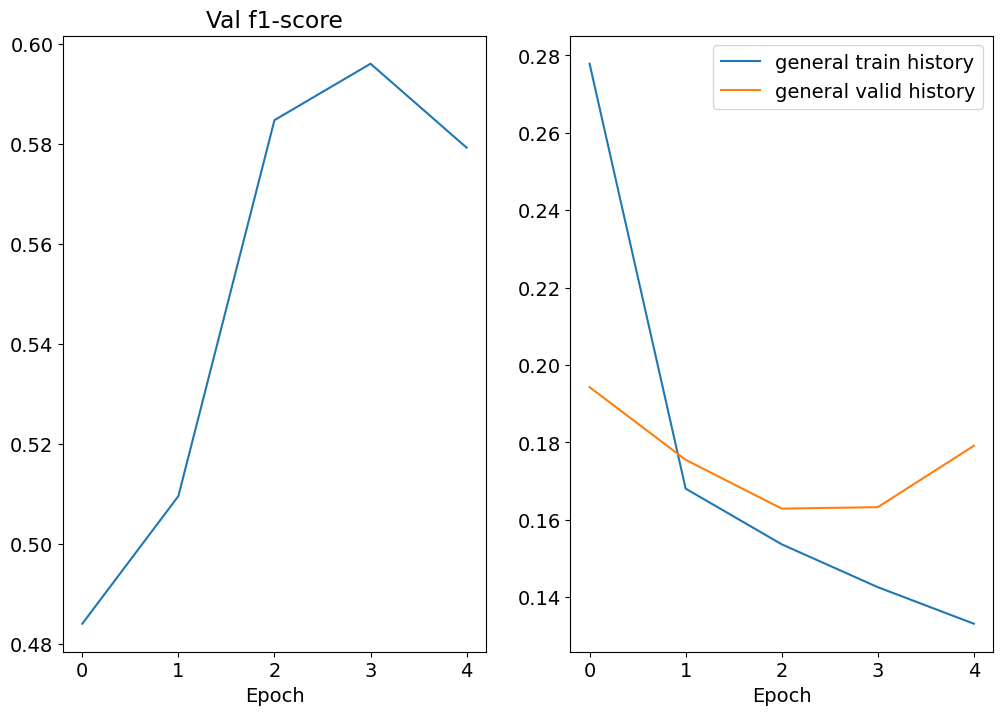

Epoch: 05 | Time: 2m 34s
	Train Loss: 0.133
	 Val. Loss: 0.179 |  Val. F1: 0.579


In [ ]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

In [ ]:
bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_clf.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.9086021505376344,0.4435695538057743,0.5961199294532628


### Prediction on test set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

In [ ]:
assert len(true_labels) == len(pred_labels)

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_df.head()

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph,label,linearized_graph,true_y,prediction
0,0,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Clash of Kings,Q1213715,Q300370,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q300370', 'id': 1, 'label': 'A Clash of Kings'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> A Clash of Kings </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
1,1,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Feast for Crows,Q1213715,Q1764445,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1764445', 'id': 1, 'label': 'A Feast for Crows'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> A Feast for Crows </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
2,2,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,Fear and Loathing in Las Vegas,Q1213715,Q772435,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q772435', 'id': 1, 'label': 'Fear and Loathing in Las Vegas'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> Fear and Loathing in Las Vegas </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
3,3,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,In Cold Blood,Q1213715,Q1142887,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1142887', 'id': 1, 'label': 'In Cold Blood'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> In Cold Blood </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
4,4,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,Into the Woods,Q1213715,Q1118244,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1118244', 'id': 1, 'label': 'Into the Woods'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"

In [ ]:
test_pred_path = "test_pred_linearized_graph_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

## Linearized graph only

In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)

In [ ]:
idx_bound = 5
for i in range(idx_bound):
    d = train_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)


 <s> iran , country , iran iran , replaces , pahlavi dynasty pahlavi dynasty , replaced by , iran </s> ruhollah khomeini ' s return to iran </s> , country , pahlavi dynasty </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 <s> iran , described by source , jewish encyclopedia of brockhaus and efron iran , country , iran letter , described by source , jewish encyclopedia of brockhaus and efron letter , subclass of , written work the book of healing , country of origin , iran the book of healing , instance of , written work </s> ruhollah khome

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

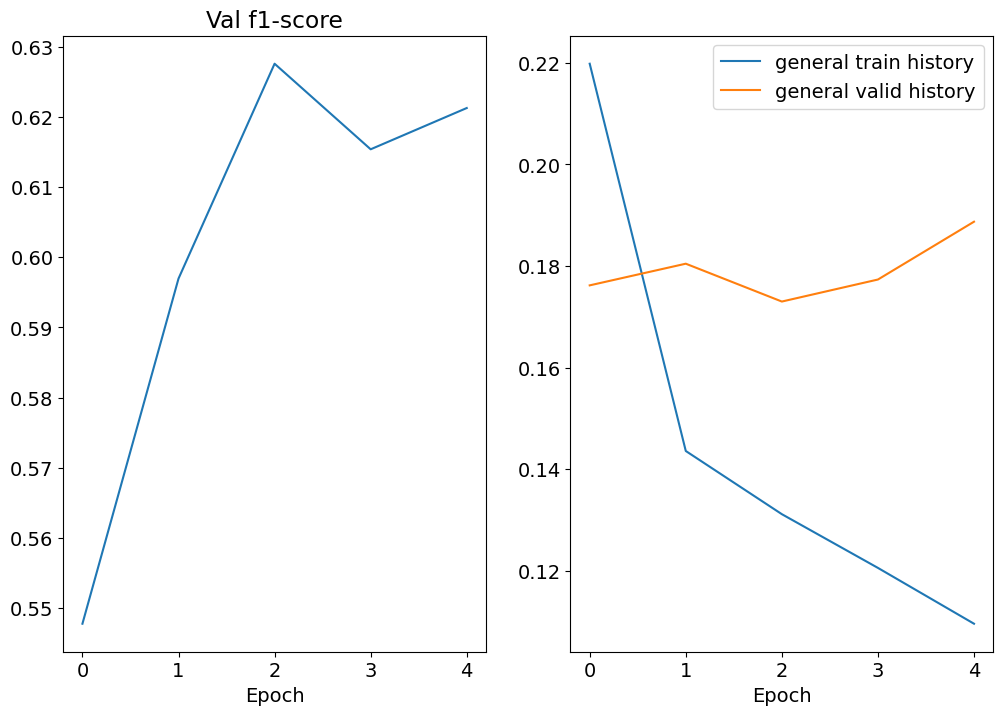

Epoch: 05 | Time: 2m 34s
	Train Loss: 0.110
	 Val. Loss: 0.189 |  Val. F1: 0.621


In [ ]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_only_clf", device)

In [ ]:

bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_only_clf.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.792,0.5196850393700787,0.6275752773375594


### Prediction on test set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

In [ ]:
assert len(true_labels) == len(pred_labels)

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_df.head()

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph,label,linearized_graph,true_y,prediction
0,0,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Clash of Kings,Q1213715,Q300370,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q300370', 'id': 1, 'label': 'A Clash of Kings'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> A Clash of Kings </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
1,1,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Feast for Crows,Q1213715,Q1764445,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1764445', 'id': 1, 'label': 'A Feast for Crows'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> A Feast for Crows </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
2,2,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,Fear and Loathing in Las Vegas,Q1213715,Q772435,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q772435', 'id': 1, 'label': 'Fear and Loathing in Las Vegas'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> Fear and Loathing in Las Vegas </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
3,3,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,In Cold Blood,Q1213715,Q1142887,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1142887', 'id': 1, 'label': 'In Cold Blood'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> In Cold Blood </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
4,4,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,Into the Woods,Q1213715,Q1118244,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1118244', 'id': 1, 'label': 'Into the Woods'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"

In [ ]:
test_pred_path = "test_pred_linearized_graph_only_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)